# Анализ компьютерных игр

Интернет-магазине «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Гипотезы исследования:**

- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
- средние пользовательские рейтинги жанров Action и Sports разные.

**Этапы исследования:**

1. Изучение общей информации
2. Предварительная обработка данных
3. Исследовательский анализ данных
4. Составление портрета пользователя каждого региона
5. Проверка гипотез
6. Общий вывод

<a name="h1"></a>
### 1. Изучение общей информации

#### Импорт библиотек

In [1]:
#импорт библиотеки pandas
import pandas as pd

#импорт библиотеки numpy
import numpy as np

#импорт библиотеки matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

#импорт библиотеки seaborn
import seaborn as sns

#импорт модуля scipy
from scipy import stats as st

#### Настройка

In [2]:
#отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

#отображение всех колонок
pd.set_option('display.max_columns', None)

#### Анализ файла

In [3]:
#чтение файла
df = pd.read_csv('games.csv')

In [4]:
#вывод первых 5 строк
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
#общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
#статистические показатели
df.describe().style.format("{:.2f}")

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.00,16715.00,16715.00,16715.00,16715.00,8137.00
mean,2006.48,0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,1980.00,0.00,0.00,0.00,0.00,13.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00
50%,2007.00,0.08,0.02,0.00,0.01,71.00
75%,2010.00,0.24,0.11,0.04,0.03,79.00
max,2016.00,41.36,28.96,10.22,10.57,98.00


**Вывод**  
Представлены данные о продаже 16 715 игр за период с 1980 по 2016 гг.  Помимо названия и года выпуска доступна информация о  жанре игры, платформе, на которой игра была выпущена, продажах (в Северной Америке, Европе, Японии или в других странах), оценке критиков и пользователей и рейтинге от организации ESRB.  
Всего в таблице 11 столбцов. Типы данных в каждом столбце соответствуют логике содержащейся в них информации, кроме года выпуска и оценки пользователей. Также в половине столбцов можно отметить проблему пропущенных данных, без которых проведение качественного анализа невозможно.

<a name="h2"></a>
### 2. Предварительная обработка данных

#### Преобразование названий столбцов

In [7]:
#приведение к нижнему регистру названий столбцов
df.columns = df.columns.str.lower()

#### Добавление нового столбца

In [8]:
#суммарные продажи во всех регионах
df['global_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

#### Обработка пропусков

In [9]:
#доля пропущенных значений в каждом столбце
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
global_sales       0.000000
dtype: float64

In [10]:
#количество пропущенных данных в name и genre совпадает
#проверим, не относится ли это к одним и тем же строкам DataFrame
df[df['name'].isnull() & df['genre'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


В половине столбцов есть пропущенные значения:

1. name;
2. year_of_release;
3. genre;
4. critic_score;
5. user_score;
6. rating.

Идентифицировать игры без названия на основании имеющихся данных не представляется возможным, поэтому исключим 2 игры с пропусками в столбцах *name* и *genre* из выборки.  
Недостающие данные в *year_of_release* заполним на основании имеющийся информации (если игра выпускалась на нескольких платформах, то год выпуска должен быть примерно одинаковым для каждой из них).    
Пропуски в *critic_score* и *user_score* оставим без изменений, поскольку отсутствие таких параметров также является индикатором. Возможно, они указывают на невысокую популярность игры, вследствие чего она осталась без особого внимания критиков и пользователей.   
Что касается рейтинга ESRB, то его получение не является обязательным, поэтому не исключено, что пропуск данных не является ошибкой. Заменим пропущенные данные в *rating* значением "no_rating", чтобы в дальнейшем оценить влияние отсутствия рейтинга на популярность игры.

##### Пропуски в *name*  и *genre*

In [11]:
#исключение строк с пропусками в name и genre
df = df[pd.notnull(df['name'])]

##### Пропуски в *year_of_release*

In [12]:
#создание DataFrame наименование игры - год выпуска
d1 = df[['name', 'year_of_release']]

In [13]:
#удаление строк без года выпуска
d1 = d1[pd.notnull(d1['year_of_release'])]

In [14]:
#удаление дублирующих строк
d1 = d1.drop_duplicates(subset=['name'], keep='first')

In [15]:
#добавление данных в исходный DataFrame
df = df.merge(d1, on='name', how='left')

In [16]:
#заполнение недостающих данных
df.loc[df['year_of_release_x'].isna(), 'year_of_release_x'] = df['year_of_release_y']

In [17]:
df.isna().mean()

name                 0.000000
platform             0.000000
year_of_release_x    0.008736
genre                0.000000
na_sales             0.000000
eu_sales             0.000000
jp_sales             0.000000
other_sales          0.000000
critic_score         0.513133
user_score           0.400826
rating               0.404715
global_sales         0.000000
year_of_release_y    0.008736
dtype: float64

Оставшиеся пропуски составляют всего 0,9% от всей выборки. Удалим их, а также дублирующий столбец *year_of_release_y*.

In [18]:
df = df[pd.notnull(df['year_of_release_x'])]

In [19]:
df.drop(['year_of_release_y'], axis='columns', inplace=True)

##### Пропуски в ratings

In [20]:
#заполнение пропусков значением "no_rating"
df['rating'] = df['rating'].fillna('no_rating')

##### Проверка

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               16567 non-null  object 
 1   platform           16567 non-null  object 
 2   year_of_release_x  16567 non-null  float64
 3   genre              16567 non-null  object 
 4   na_sales           16567 non-null  float64
 5   eu_sales           16567 non-null  float64
 6   jp_sales           16567 non-null  float64
 7   other_sales        16567 non-null  float64
 8   critic_score       8075 non-null   float64
 9   user_score         9934 non-null   object 
 10  rating             16567 non-null  object 
 11  global_sales       16567 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


In [22]:
#переименуем столбец year_of_release_x
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 
              'other_sales', 'critic_score', 'user_score', 'rating', 'global_sales']

#### Преобразование типа данных

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16567 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16567 non-null  object 
 1   platform         16567 non-null  object 
 2   year_of_release  16567 non-null  float64
 3   genre            16567 non-null  object 
 4   na_sales         16567 non-null  float64
 5   eu_sales         16567 non-null  float64
 6   jp_sales         16567 non-null  float64
 7   other_sales      16567 non-null  float64
 8   critic_score     8075 non-null   float64
 9   user_score       9934 non-null   object 
 10  rating           16567 non-null  object 
 11  global_sales     16567 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


В целом типы данных в столбцах не противоречат логике содержащейся в них информации, однако необходимо обратить внимание на столбцы *user_score* и *year_of_release*.

##### Изменение типа данных user_score

In [24]:
#тип данных object указывает на наличие нечисловых значений в столбце user_score
#необходимо выявить такие нечисловые значения
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В данных встречается значение tbd. TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Поскольку данный статус равнозначен отсутствию оценки (оценка игре еще не дана), заменим это значение на None.

In [25]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = None

In [26]:
#изменение типа данных с object на float
df['user_score'] = pd.to_numeric(df['user_score'])

##### Изменение типа данных year_of_release

In [27]:
df['year_of_release'] = df['year_of_release'].astype(int)

<a name="h3"></a>
### 3. Исследовательский анализ данных

#### Динамика выпуска игр за период 1980 - 2016

In [28]:
#группировка игр по году выпуска
df_by_year = df.pivot_table(index = 'year_of_release', values='name', aggfunc='count')

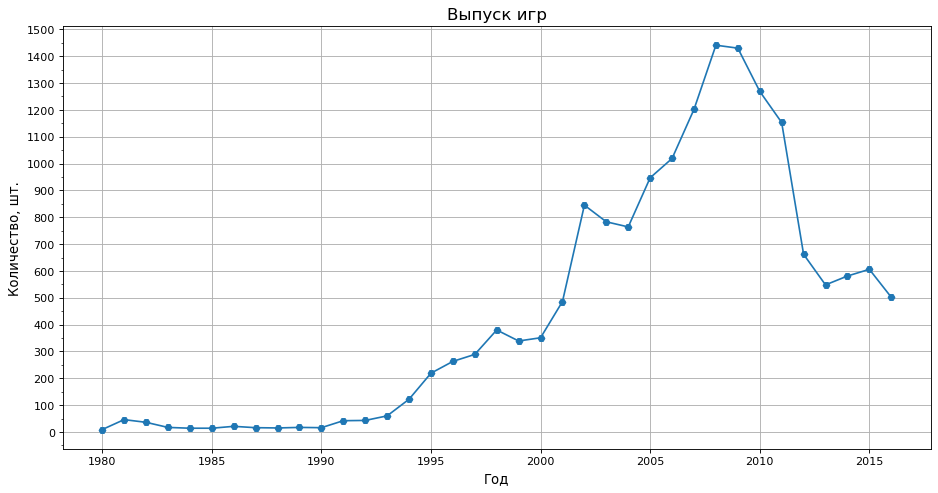

In [29]:
#график динамики выпуска игр
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)   
df_by_year['name'].plot(marker = 'H')
#форматирование графика
plt.title('Выпуск игр', fontsize=15)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество, шт.', fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
plt.grid(True)
plt.show()

In [30]:
#доля игр, выпущенных до 1995 года
df_by_year = df_by_year.reset_index()
np.round(df_by_year[df_by_year['year_of_release'] < 1995]['name'].sum() / df_by_year['name'].sum(), 2)

0.03

За период 1980 - 1994 было выпущено всего 3% игр. Исключим их из выборки.

In [31]:
df_1995 = df.query('year_of_release >= 1995')

#### Анализ продаж по платформам

In [32]:
#группировка продаж по платформам и годам выпуска игр
df_by_platforms = df_1995.pivot_table(index = 'year_of_release', columns='platform', values='global_sales',  
                         margins=True, margins_name='total', fill_value=0, aggfunc='sum')

In [33]:
#сортировка платформ по продажам
df_by_platforms.sort_values(by='total', axis=1, ascending=False)

platform,total,PS2,X360,PS3,Wii,DS,PS,PS4,GBA,PSP,3DS,XB,PC,N64,GC,XOne,GB,WiiU,PSV,SNES,SAT,DC,WS,NG,TG16,3DO,PCFX
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,88.12,0.00,0.00,0.00,0.00,0.00,35.96,0.00,0.00,0.00,0.00,0.00,4.22,0.00,0.00,0.00,3.60,0.00,0.00,32.20,11.57,0.00,0.00,0.33,0.16,0.08,0.00
1996,199.15,0.00,0.00,0.00,0.00,0.00,94.70,0.00,0.00,0.00,0.00,0.00,10.58,34.10,0.00,0.00,36.03,0.00,0.00,15.92,7.69,0.00,0.00,0.10,0.00,0.00,0.03
1997,201.07,0.00,0.00,0.00,0.00,0.00,136.17,0.00,0.00,0.00,0.00,0.00,11.27,39.50,0.00,0.00,6.37,0.00,0.00,0.99,6.77,0.00,0.00,0.00,0.00,0.00,0.00
1998,257.26,0.95,0.00,0.00,0.00,0.00,169.49,0.00,0.00,0.00,0.00,0.00,3.26,49.24,0.00,0.00,26.90,0.00,0.00,0.22,3.82,3.38,0.00,0.00,0.00,0.00,0.00
1999,251.25,0.00,0.00,0.00,0.00,0.00,144.53,0.00,0.00,0.00,0.00,0.00,4.74,58.01,0.00,0.00,38.00,0.00,0.00,0.26,0.09,5.16,0.46,0.00,0.00,0.00,0.00
2000,201.68,39.17,0.00,0.00,0.00,0.00,96.37,0.00,0.07,0.00,0.02,0.99,4.66,33.97,0.00,0.00,19.76,0.00,0.00,0.00,0.00,5.99,0.68,0.00,0.00,0.00,0.00
2001,333.30,166.43,0.00,0.00,0.00,0.00,35.59,0.00,61.53,0.00,0.00,23.82,5.47,3.25,26.62,0.00,9.24,0.00,0.00,0.00,0.00,1.07,0.28,0.00,0.00,0.00,0.00
2002,401.42,208.36,0.00,0.00,0.00,0.00,6.67,0.00,74.16,0.00,0.00,51.00,8.57,0.08,52.29,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00
2003,366.93,193.05,0.00,0.00,0.00,0.00,2.07,0.00,56.67,0.00,0.00,55.05,8.89,0.00,51.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Можно выделить ТОП-5 игровых платформ с максимальными продажами: **PS2, X360, PS3, Wii, DS. PS** также демонстрирует высокие продажи, однако последняя игра на ней была выпущена еще в 2003 году, поэтому рассматривать ее мы не будем.

In [34]:
#формирование сводной таблицы для графиков
df_by_platforms = df_1995.pivot_table(index = 'year_of_release', columns='platform', values='global_sales', aggfunc='sum')

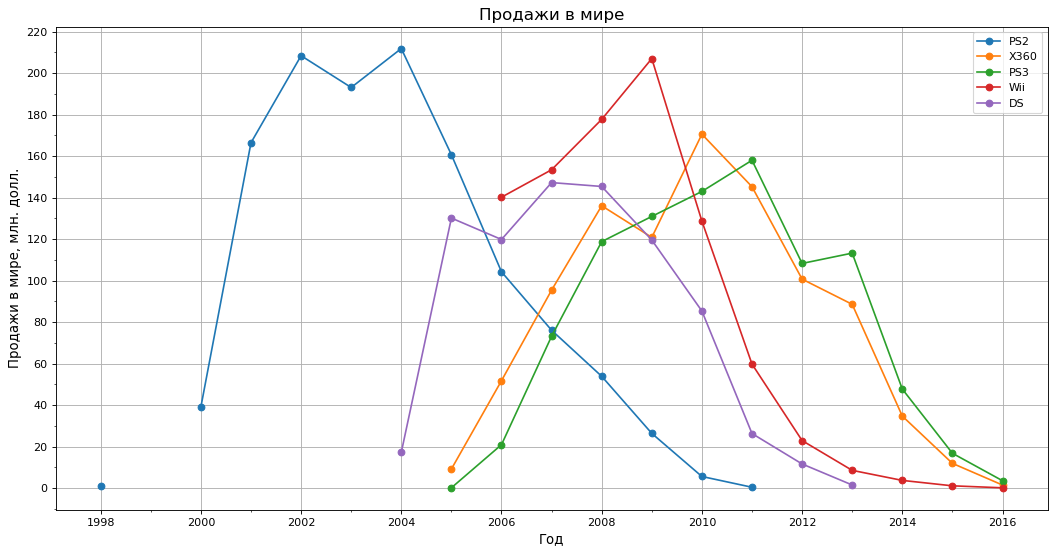

In [35]:
#график распределения продаж по годам по ТОП-5 платформам
fig, ax = plt.subplots(figsize=(16,8), dpi= 80)    
df_by_platforms['PS2'].plot(marker = 'o')
df_by_platforms['X360'].plot(marker = 'o')
df_by_platforms['PS3'].plot(marker = 'o')
df_by_platforms['Wii'].plot(marker = 'o')
df_by_platforms['DS'].plot(marker = 'o')

#форматирование графика
plt.title('Продажи в мире', fontsize=15)
plt.legend()
plt.xlabel('Год', fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.ylabel('Продажи в мире, млн. долл.', fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.grid(True)

In [36]:
#средняя продолжительность жизни игровой платформы
np.round(df_by_platforms.count().mean(), 2)

7.38

#### Анализ данных за актуальный период

На предыдущем этапе мы определили, что в среднем игровая платформа обновляется каждые 7-8 лет. Определим период с 2010 по 2016 как актуальный период. 

In [37]:
df_2010 = df.query('year_of_release >= 2010')

In [38]:
#группировка игр по платформам
df_by_platforms2 = df_2010.pivot_table(index = 'year_of_release', columns='platform', values='global_sales',  
                         margins=True, margins_name='total', fill_value=0, aggfunc='sum')

In [39]:
#сортировка платформ по продажам
df_by_platforms2.sort_values(by='total', axis=1, ascending=False)

platform,total,PS3,X360,PS4,3DS,Wii,XOne,DS,PC,WiiU,PSP,PSV,PS2
year_of_release,,,,,,,,,,,,,
2010,594.66,142.96,170.55,0.00,0.30,128.67,0.00,85.35,26.15,0.00,35.04,0.00,5.64
2011,510.59,157.98,145.23,0.00,63.20,59.79,0.00,26.33,35.16,0.00,17.82,4.63,0.45
2012,360.52,108.28,100.72,0.00,51.76,22.94,0.00,11.67,23.45,17.56,7.95,16.19,0.00
2013,362.11,113.25,88.58,25.99,56.57,8.59,18.96,1.54,13.01,21.65,3.38,10.59,0.00
2014,331.53,47.76,34.74,100.00,43.76,3.75,54.07,0.00,13.28,22.03,0.24,11.90,0.00
2015,267.98,16.82,11.96,118.90,27.78,1.14,60.14,0.00,8.52,16.35,0.12,6.25,0.00
2016,129.94,3.60,1.52,69.25,15.14,0.18,26.15,0.00,5.25,4.60,0.00,4.25,0.00
total,2557.33,590.65,553.30,314.14,258.51,225.06,159.32,124.89,124.82,82.19,64.55,53.81,6.09


С большим отрывом лидируют две платформы: **PS3** и **X360**. Посмотрим на общую динамику продаж всех платформ.

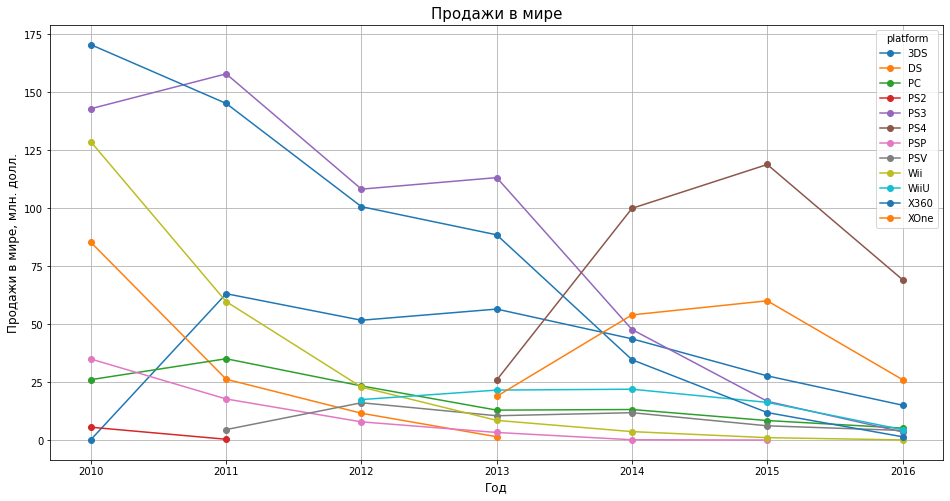

In [40]:
df_2010.pivot_table('global_sales', index = 'year_of_release', columns='platform', 
                    aggfunc='sum').plot(figsize=(16,8), marker = 'o')
plt.title('Продажи в мире', fontsize=15)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Продажи в мире, млн. долл.', fontsize=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.grid(True)

Все 12 платформ показывают снижение продаж в 2016 относительно 2015, что скорее всего обусловлено неполнотой данных в последний анализируемый год. Большинство игровых платформ показывали отрицательную динамику и в более ранние периоды, однако **XOne** и **PS4** еще имеют некоторый потенциал роста, поскольку вышли на рынок только в 2013 году (на смену Х360 и PS3) и до 2016 года их продажи росли. Также к потенциально прибыльным платформам можно отнести **3DS** (предшественницей которой является платформа DS) и, конечно, **PC**, поскольку игры на персональном компьютере занимают отдельную нишу в игровой индустрии. Что касается **WiiU** (предыдущая версия - Wii - самая успешная консоль Nintendo, однако в 2016 году ее продажи почти сошли на нет) и **PSV** (пришла на смену PSP в 2012), то их продажи даже в самый пиковый год (2014) были не очень высокими, а учитывая темпы снижения данного показателя, существенная прибыль в следующем году не ожидается.

#### Анализ потенциально прибыльных платформ

In [41]:
#список потенциально прибыльных платформ
actual_platforms = ['XOne', 'PS4', '3DS', 'PC']

In [42]:
#срез данных по актуальным платформам
df_actual_platforms = df_2010.query('platform in @actual_platforms')

(0.0, 3.0)

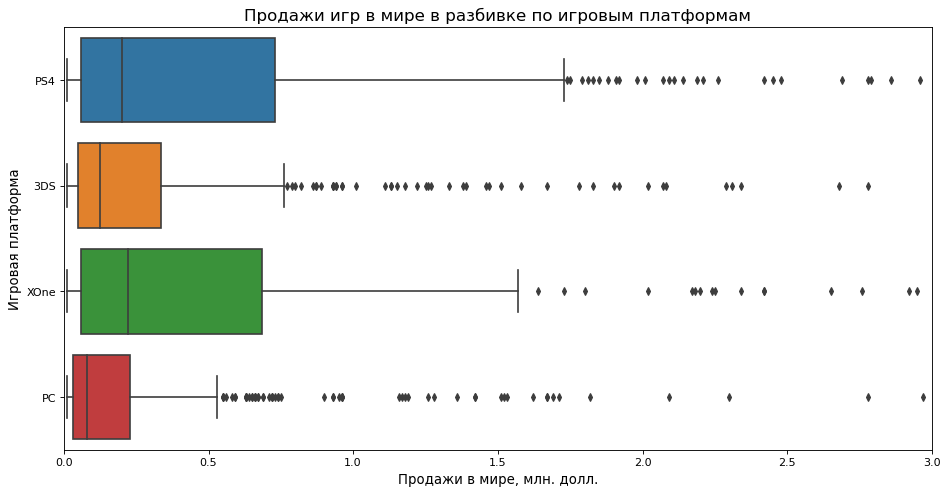

In [43]:
#boxplot по актуальным платформам
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)  
sns.boxplot(y="platform", x="global_sales", data=df_actual_platforms, orient="o")
plt.title('Продажи игр в мире в разбивке по игровым платформам', fontsize=15)
plt.xlabel('Продажи в мире, млн. долл.', fontsize=12)
plt.ylabel('Игровая платформа', fontsize=12)
plt.xlim(0, 3)

Boxplot показывает нам, что в среднем продажи каждой отдельной игры **PS4** и **XOne** гораздо выше, чем продажи игр **3DS** и **PC**. При этом максимальная продажа (без выбросов) **3DS** примерно на уровне 75 перцентиля продаж **PS4** и **XOne**.  
Смещение медиан на каждом графике говорит о наличии отдельных игр, пользующихся нетипично высоким спросом среди пользователей (либо игр с очень высокой ценой) и завышающих среднее значение продаж.

In [44]:
#величина средней продажи по каждой отдельной платформе
df_actual_platforms['global_sales'].groupby(df_actual_platforms['platform']).describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,514.0,0.502938,1.438494,0.01,0.05,0.125,0.3375,14.60
PC,488.0,0.255779,0.529919,0.01,0.03,0.080,0.2300,5.14
PS4,392.0,0.801378,1.609456,0.01,0.06,0.200,0.7300,14.63
XOne,247.0,0.645020,1.036139,0.01,0.06,0.220,0.6850,7.39


Лидерство **3DS**, относительно **XOne** по общим продажам, обусловлено исключительно количеством выпущенных игр, а не их стоимостью, хоть и продажи самой популярной игры **3DS** в 2 раза выше, чем у **XOne**.  
Средние продажи отдельной игры, выпущенной на **PS4**, значительно выше (от 25% до 200%), чем на любой другой рассматриваемой платформе.  
Продажи **PC** наиболее однородны - стандартное отклонение почти в 5 раз меньше среднего значения.

#### Корреляционный анализ продаж внутри платформ

In [45]:
#DataFrame только с продажами, платформами и оценками пользователей и критиков
df_2010_corr = df_2010[['global_sales', 'platform', 'critic_score', 'user_score']]

In [46]:
#функция для построения совместного распределения с подбором регрессии
def platform_analysis(platform, data):
    sns.jointplot("critic_score", "global_sales", data=data[data['platform'] == platform], kind='reg').fig.suptitle(
    'График совместного распределения оценки критиков и продаж в мире с подбором регрессии', fontsize=14, y=1.02) 
    plt.xlabel('Оценка критиков', fontsize=12)
    plt.ylabel('Продажи в мире, млн. долл.', fontsize=12)
    sns.jointplot("user_score", "global_sales", data=data[data['platform'] == platform], kind='reg').fig.suptitle(
    'График совместного распределения оценки пользователей и продаж в мире с подбором регрессии', fontsize=14, y=1.02)
    plt.xlabel('Оценка пользователей', fontsize=12)
    plt.ylabel('Продажи в мире, млн. долл.', fontsize=12)

##### Корреляционный анализ PS4

,global_sales,critic_score,user_score
global_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


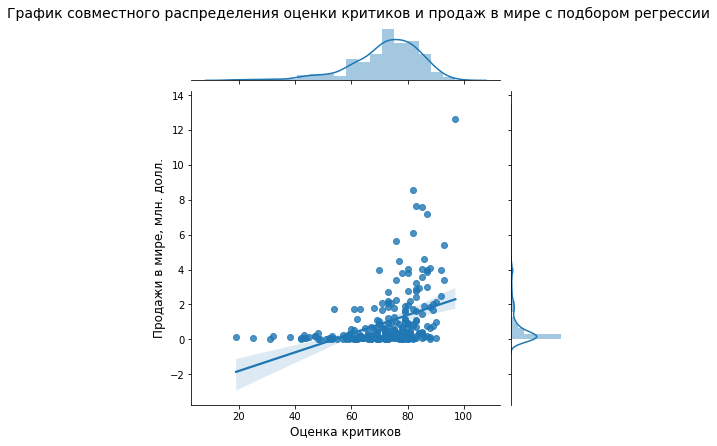

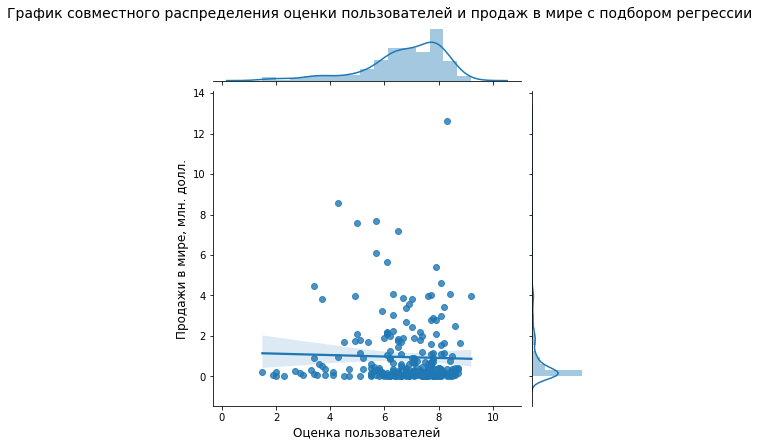

In [47]:
#корреляционная матрица
platform_analysis('PS4', df_2010_corr)
#график совместного распределения с подбором регрессии
df_2010_corr[df_2010_corr['platform'] == 'PS4'].corr().style.background_gradient(cmap = 'coolwarm')

**Вывод**  
Корреляционный анализ показал не ярко выраженную положительную связь между оценкой критиков и продажами игры и отсутствие связи между оценкой пользователей и популярностью игры.  

##### Корреляционный анализ XOne, 3DS, PC

###### XOne

,global_sales,critic_score,user_score
global_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


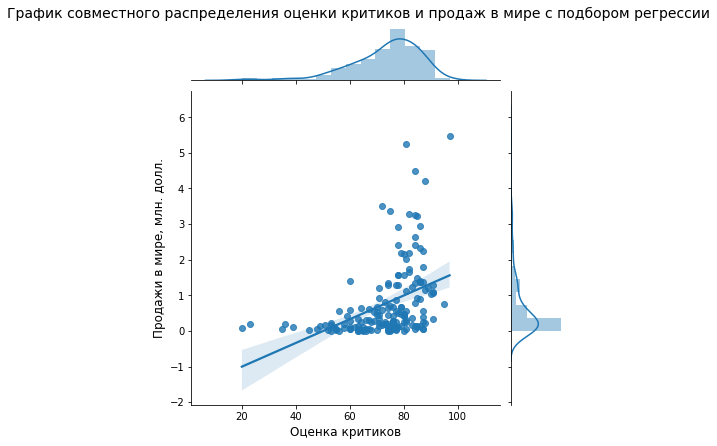

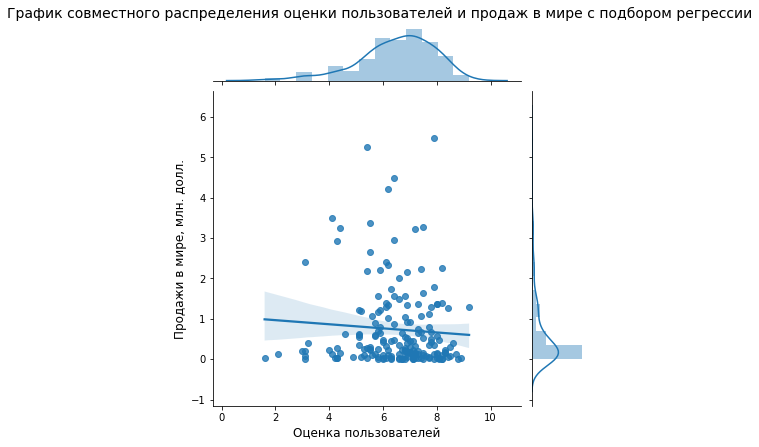

In [48]:
platform_analysis('XOne', df_2010_corr)
df_2010_corr[df_2010_corr['platform'] == 'XOne'].corr().style.background_gradient(cmap = 'coolwarm')

###### 3DS

,global_sales,critic_score,user_score
global_sales,1.000000,0.348216,0.222305
critic_score,0.348216,1.000000,0.744286
user_score,0.222305,0.744286,1.000000


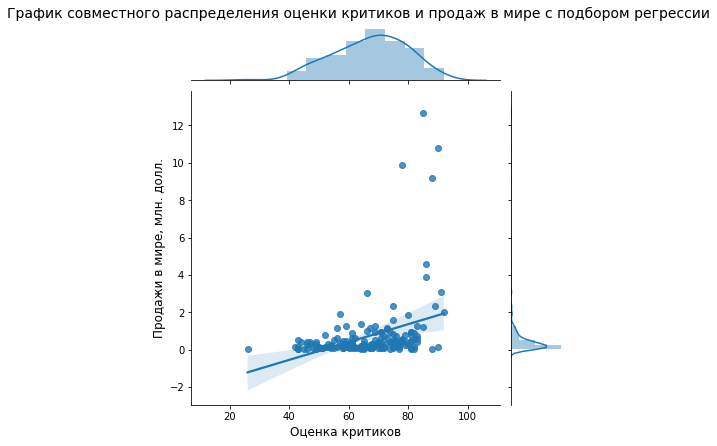

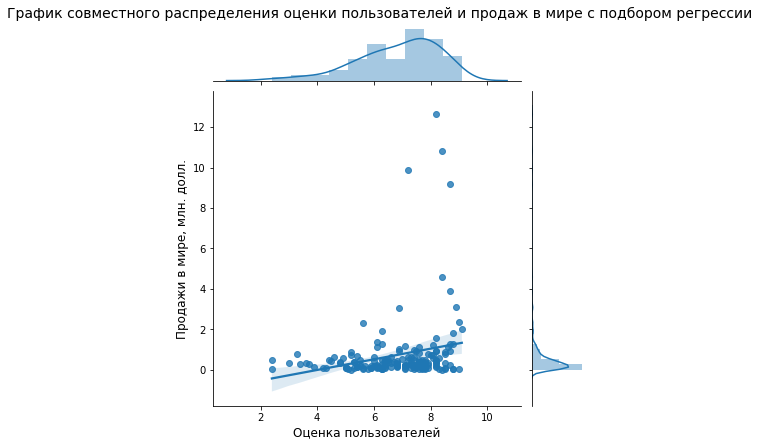

In [49]:
platform_analysis('3DS', df_2010_corr)
df_2010_corr[df_2010_corr['platform'] == '3DS'].corr().style.background_gradient(cmap = 'coolwarm')

##### PC

,global_sales,critic_score,user_score
global_sales,1.000000,0.337270,-0.016365
critic_score,0.337270,1.000000,0.478382
user_score,-0.016365,0.478382,1.000000


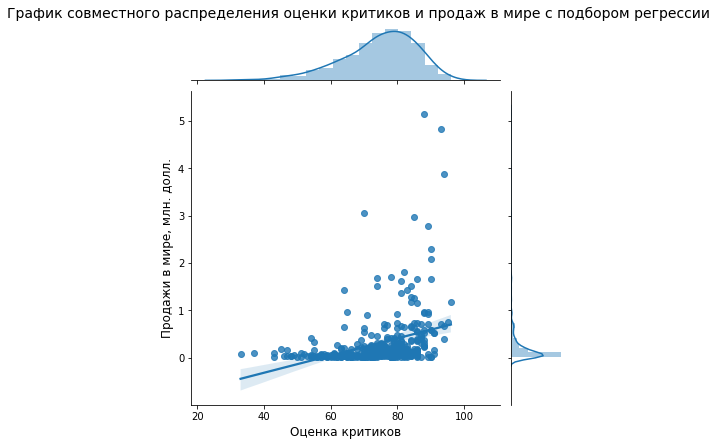

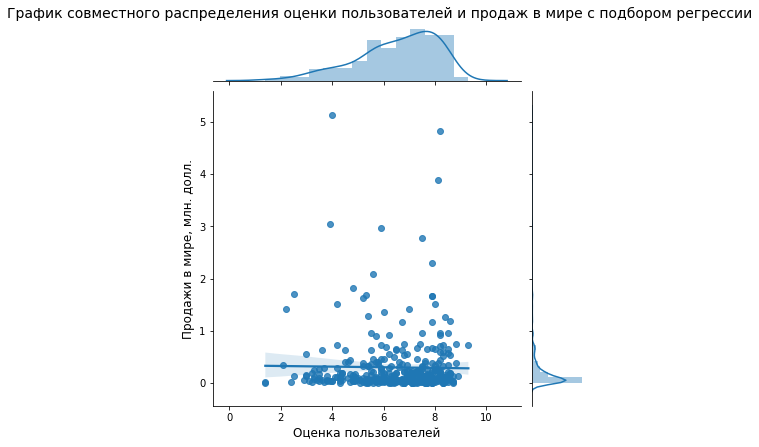

In [50]:
platform_analysis('PC', df_2010_corr)
df_2010_corr[df_2010_corr['platform'] == 'PC'].corr().style.background_gradient(cmap = 'coolwarm')

**Вывод**  
В целом, картина типична для каждой платформы: оценка критиков положительно, но не значительно коррелирует с уровнем продаж, в то время как связь между оценкой пользователей и продажами не обнаруживается.

#### Анализ продаж по жанрам

In [51]:
#пропишем функцию для создания столбчатых графиков
def sns_barplot(data, x, y):
    plt.figure(figsize=(16,6))
    ax = sns.barplot(x=x, y=y, data=data, palette=sns.color_palette("GnBu", 12))
    ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)

    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            height = 0
        ax.text(p.get_x() + p.get_width()/2., height, '{:1.1%}'.format(height), 
            fontsize=11, ha='center', va='bottom')

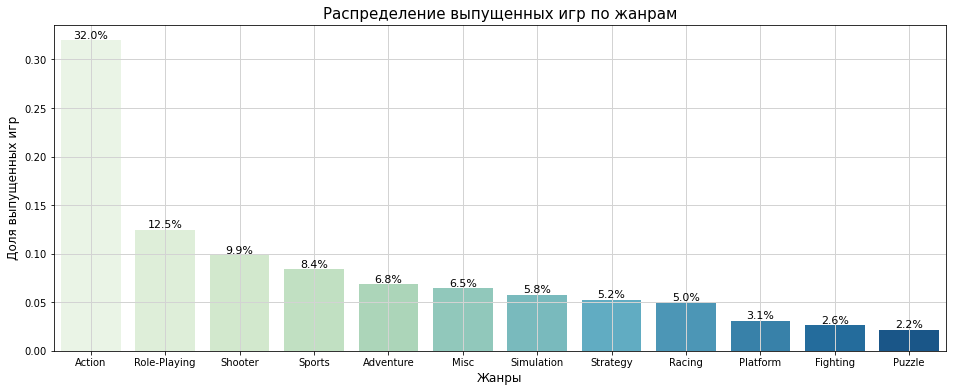

In [52]:
#распределение выпущенных игр по жанрам
report = df_actual_platforms.groupby('genre').agg({'global_sales': 'count'}).reset_index().sort_values('global_sales', 
                                                                                                       ascending=False)
report['part'] = round(report['global_sales'] / sum(report['global_sales']),4)

sns_barplot(report, 'genre', 'part')

plt.title("Распределение выпущенных игр по жанрам", fontsize = 15)
plt.xlabel("Жанры", fontsize = 12, fontweight=500)
plt.ylabel('Доля выпущенных игр', fontsize = 12, fontweight=500);

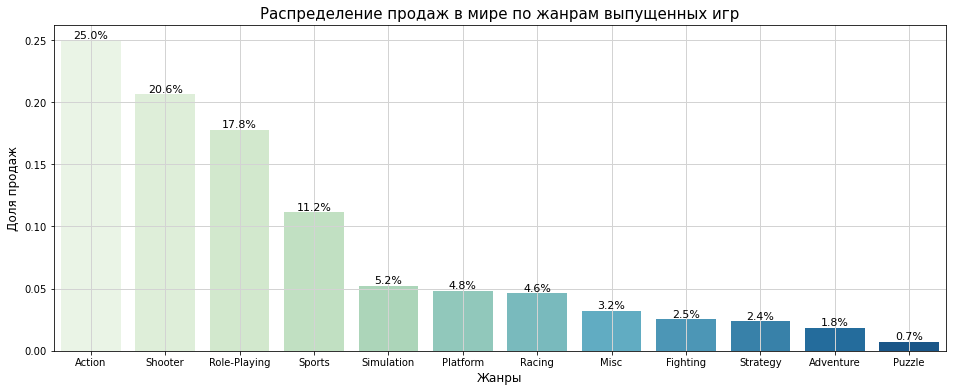

In [53]:
#распределение жанров по величине продаж
report = df_actual_platforms.groupby('genre').agg({'global_sales': 'sum'}).reset_index().sort_values('global_sales', 
                                                                                                       ascending=False)
report['part'] = round(report['global_sales'] / sum(report['global_sales']),4)

sns_barplot(report, 'genre', 'part')

plt.title("Распределение продаж в мире по жанрам выпущенных игр", fontsize = 15)
plt.xlabel("Жанры", fontsize = 12, fontweight=500)
plt.ylabel('Доля продаж', fontsize = 12, fontweight=500);

In [54]:
#рассчитаем средние продажи по каждому жанру
report = df_actual_platforms.groupby('genre').agg({'global_sales': 'mean'}).reset_index()

In [55]:
report.sort_values('global_sales')

,genre,global_sales
1,Adventure,0.141696
5,Puzzle,0.173333
11,Strategy,0.238488
3,Misc,0.260849
0,Action,0.407886
9,Simulation,0.471263
6,Racing,0.481707
2,Fighting,0.506744
10,Sports,0.693188
7,Role-Playing,0.742634


**Вывод**  
Наиболее прибыльным жанром является **Shooter**. Несмотря на то, что в таком жанре было выпущено всего 10% игр, они обеспечили 21% от всех продаж.  
Наименее выгодным жанром является **Adventure**. Почти 7% игр выпускается в таком жанре, однако принесли они менее 2% продаж в общей структуре.  
Самыми востребованными являются игры **Action**, а самыми непопулярными **Puzzle** (32% и 2,2% выпущенных игр соответственно). 

<a name="h4"></a>
### 4. Составление портрета пользователя каждого региона

In [56]:
#функция для создания круговой диаграммы по платформам
def top_platforms(data, kind, region):
    #круговая диаграмма
    report = data.groupby(kind).agg({region: 'sum'}).reset_index()
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    ax.pie(report[region], 
           labels=report[kind], 
           autopct='%1.1f%%', 
           pctdistance = 0.6, 
           rotatelabels=False,
           labeldistance=0.8)
    plt.rcParams['font.size'] = 11
    ax.axis("equal")

In [57]:
#функция для определения ТОП-5 жанров
def top_genres(data, region):
    top_genre = data.groupby('genre').agg({region: 'sum'}).reset_index()
    top_genre['share'] = np.round(top_genre[region] / top_genre[region].sum(), 2)
    print(top_genre.sort_values('share', ascending=False).head())

In [58]:
#функция для определения зависимости продаж от рейтинга ESRB
def ESRB(data, region):
    report = data.groupby('rating').agg({region: 'mean'})
    report[region].plot(grid=True, figsize=(7, 4), marker = 'o')
    plt.title('Средние продажи игры в зависимости от рейтинга ESRB', fontsize=14)
    plt.xlabel('Рейтинг ESRB', fontsize=12)
    plt.ylabel('Средние продажи, млн. долл.', fontsize=12)

#### Северная Америка

Text(0.5, 1.0, 'Распределение продаж компьютерных игр в Северной Америке между игровыми платформами')

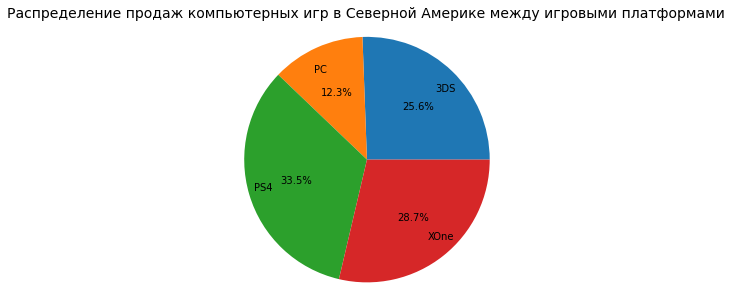

In [59]:
#распределение платформ по величине продаж
top_platforms(df_actual_platforms, 'platform', 'na_sales')
plt.title('Распределение продаж компьютерных игр в Северной Америке между игровыми платформами', fontsize=14)

In [60]:
#ТОП-5 жанров
top_genres(df_actual_platforms, 'na_sales')

           genre  na_sales  share
0         Action     81.06   0.25
8        Shooter     79.08   0.24
7   Role-Playing     52.17   0.16
10        Sports     37.39   0.12
4       Platform     16.26   0.05


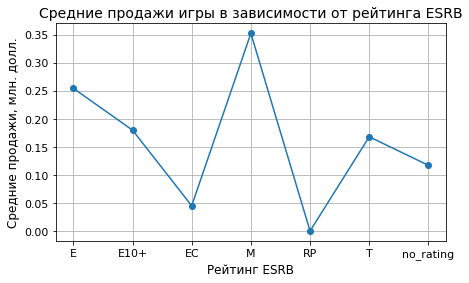

In [61]:
#определение зависимости продаж от рейтинга ESRB
ESRB(df_actual_platforms, 'na_sales')

**Вывод**  
Каждый третий игрок, проживающий в Северной Америке, предпочитает игры, выпущенные на платформе **PS4**. Чуть меньшим спросом пользуются игровые платформы **XOne** и **3DS**, хотя вместе им принадлежит больше половины рынка (54,3%).  
Наибольшей популярностью пользуются игры в жанре **Action** и **Shooter** - каждая вторая игра выпускается в одном из этих жанров.  
Что касается влияния рейтинга ESRB на продажи отдельной игры, то на графике четко прослеживается изменение средней цены в зависимости от рейтинга. Игры с рейтингом **М** приносят гораздо больше дохода, чем остальные категории.

#### Европа

Text(0.5, 1.0, 'Распределение продаж компьютерных игр в Европе между игровыми платформами')

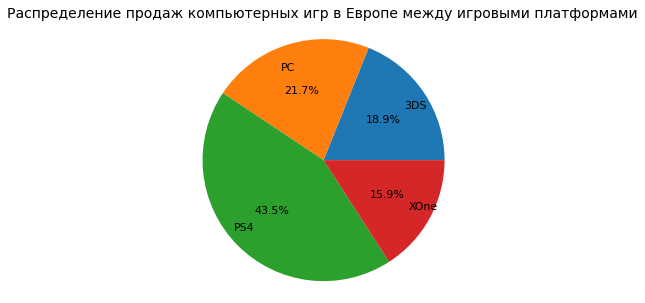

In [62]:
#распределение платформ по величине продаж
top_platforms(df_actual_platforms, 'platform', 'eu_sales')
plt.title('Распределение продаж компьютерных игр в Европе между игровыми платформами', fontsize=14)

In [63]:
#ТОП-5 жанров
top_genres(df_actual_platforms, 'eu_sales')

           genre  eu_sales  share
0         Action     81.00   0.25
8        Shooter     72.07   0.22
7   Role-Playing     42.86   0.13
10        Sports     42.55   0.13
6         Racing     18.73   0.06


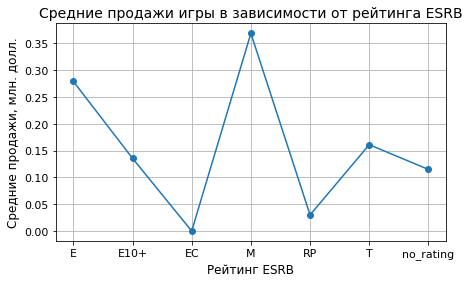

In [64]:
#определение зависимости продаж от рейтинга ESRB
ESRB(df_actual_platforms, 'eu_sales')

**Вывод**  
Игроки из Европы гораздо чаще отдают предпочтение платформе **PS4**. Вторая по популярности платформа - **РС** - пользуется в два раза меньшим спросом.  
Вкусовые предпочтения европейцев в части жанров очень схожи с предпочтениями игроков Северной Америки, за исключением того, что в Европе чаще приобретают игры в жанре **Racing**, вместо пятого по популярности в Северной Америке жанра **Platform**.  
Обшая динамика зависимости коммерческого успеха игры от рейтинга ESRB также напоминает график по Северной Америке. Игры с рейтингом **М** приносят гораздо больше дохода, чем остальные категории.

#### Япония

Text(0.5, 1.0, 'Распределение продаж компьютерных игр в Японии между игровыми платформами')

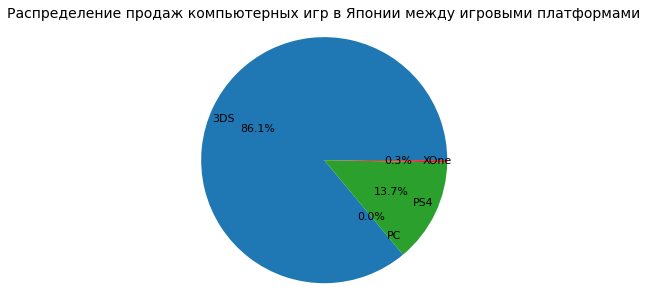

In [65]:
#распределение платформ по величине продаж
top_platforms(df_actual_platforms, 'platform', 'jp_sales')
plt.title('Распределение продаж компьютерных игр в Японии между игровыми платформами', fontsize=14)

In [66]:
#ТОП-5 жанров
top_genres(df_actual_platforms, 'jp_sales')

          genre  jp_sales  share
7  Role-Playing     45.52   0.39
0        Action     28.61   0.24
9    Simulation     10.57   0.09
4      Platform      6.97   0.06
3          Misc      5.94   0.05


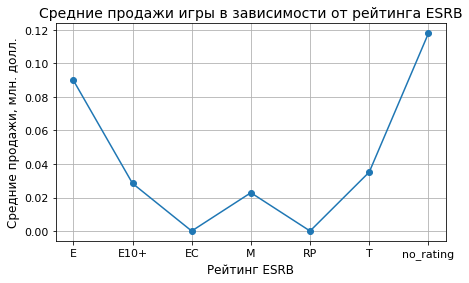

In [67]:
#определение зависимости продаж от рейтинга ESRB
ESRB(df_actual_platforms, 'jp_sales')

**Вывод**  
Японский игровой рынок представляет собой совершенно отличную картину от рынков Северной Америки и Европы. Подавляющее большинство игроков поддерживает местного производителя *Nintendo*, приобретая игры на данной платформе в 86 случаях из 100. Также присутствует небольшая доля поклонников **PS4** (13,7%). Что касается игр, выпущенных на **XOne** и **PC**, то данные платформы не вызывают интереса у японских игроков (доля продаж составляет 0,3%).  
В отличие от Северной Америки и Европы, в Японии чаще всего предпочитают игры жанра **Role-Playing**, а **Shooter** и **Sports** - довольно популярные в других странах, не находят отклик в душе японцев. Но кое-что общее у них есть - жанр **Action** также обеспечивает почти четверь продаж от всех игр, реализуемых в Японии.  
Рейтинг ESRB не имеет такого веса в Японии, как на территории других стран, что видно из представленного графика.

<a name="h5"></a>
### 5. Проверка гипотез

Нам необходимо определить, различаются ли средние пользовательские рейтинги платформ Xbox One и PC, а также есть ли разница в средних пользовательских рейтингах жанров Action и Sports. Поскольку в обоих случаях вопрос идет о равенстве средних двух независимых генеральных совокупностей, воспользуемся методом scipy.stats.ttest_ind.

**Гипотеза 1: средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

*Нулевая гипотеза H₀:* средние пользовательские рейтинги платформ Xbox One и PC одинаковые (нулевая гипотеза всегда формулируется с использованием знака равенства).  
*Альтернативная гипотеза H₁:* средние пользовательские рейтинги платформ Xbox One и PC различаются   

In [68]:
#воспользуемся методом notnull, чтобы избавиться от строк с пропусками в user_score
df_actual_platforms = df_actual_platforms[pd.notnull(df['user_score'])]

In [69]:
#формирование двух выборок по анализируемым платформам
XOne = df_actual_platforms.query('platform == "XOne"')

In [70]:
PC = df_actual_platforms.query('platform == "PC"')

In [71]:
#рассчитаем дисперсии для двух выборок
np.var(XOne['user_score'], ddof=1)

1.9069968429360702

In [72]:
np.var(PC['user_score'], ddof=1)

2.432493404234961

In [73]:
#зададим стандартный критический уровень статистической значимости
alpha = .05

In [74]:
#дисперсии отличаются на 27%. Учтем это при выполнении теста
results = st.ttest_ind(
    XOne['user_score'], 
    PC['user_score'],
    equal_var = False)

In [75]:
print('p-значение:', results.pvalue)

p-значение: 0.9519979495147267


In [76]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


**Вывод**  
С вероятностью 95% средние пользовательские рейтинги платформ Xbox One и PC равны. Нулевая гипотеза не отвергается, так как значимое различие между средними выручками отсутствует.

**Гипотеза 2: cредние пользовательские рейтинги жанров Action и Sports разные**

*Нулевая гипотеза H₀:* средние пользовательские рейтинги жанров Action и Sports одинаковые (нулевая гипотеза всегда формулируется с использованием знака равенства).  
*Альтернативная гипотеза H₁:* средние пользовательские рейтинги жанров Action и Sports различаются

In [77]:
#формирование двух выборок по анализируемым жанрам
action = df_actual_platforms.query('genre == "Action"')

In [78]:
sports = df_actual_platforms.query('genre == "Sports"')

In [79]:
#рассчитаем дисперсии для двух выборок
np.var(action['user_score'], ddof=1)

1.8195539257981024

In [80]:
np.var(sports['user_score'], ddof=1)

2.40282104534441

In [81]:
#зададим стандартный критический уровень статистической значимости
alpha = .05

In [82]:
#дисперсии отличаются на 32%. Учтем это при выполнении теста
results = st.ttest_ind(
    action['user_score'], 
    sports['user_score'],
    equal_var = False)

In [83]:
print('p-значение:', results.pvalue)

p-значение: 6.1395122246271205e-09


In [84]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


**Вывод**  
Вероятность того, что средние пользовательские рейтинги жанров Action и Sports равны стремится к 0. Нулевая гипотеза отвергается.

<a name="h6"></a>
### Общий вывод

В ходе данного исследования были изучены данные 16 715 игр за период 1980 - 2016 гг. Анализ показал, что наиболее активным рынок стал после 1995 года, что обусловлено развитием технологий, сопутствующих компьютерным играм.
В среднем, срок жизни игровой платформы составляет 7-8 лет, после чего моральный износ требует обновления платформы. Исходя из данного факта, были определены потенциально популярные продукты: **PS4**, **XOne**, **3DS** и **PC**. Выбор **PS4** и **Xone** обусловлен относительно недавним выходом на рынок (2013 год) и уверенным ростом продаж вплоть до 2015 года. **3DS** представлена на рынке с конца 2010 года, однако даже в 2016 году почти 12% доли мировых продаж приходились на эту платформу. Кроме того, данная платформа пользуется абсолютным успехом на родине в Японии (86% от всех выпускаемых игр) и отказ от нее привел бы к потере значительного рынка сбыта. Игры, выпускаемые на **РС**, занимают отдельную нишу в игровой индустрии, поэтому исключение данной платформы из рекламной компании было бы некорректным.  
Что касается жанров, то стоит обратить особое внимание на **Action**, который обеспечивает примерно четверть продаж независимо от страны реализации, а также **Role-Playing** и **Shooter**. Первый пользуется популярностью в различной степени во всех странах, а второй является наиболее доходным - занимая 10% рынка по количеству игр, он обеспечивает долю продаж в размере 21%. Остальные жанры необходимо рассматривать в контексте каждой отдельной страны, поскольку вследствие схожести менталитетов Северной Америки и Европы, предпочтения игроков очень похожи между собой, в то время как Япония демонстрирует совершенно иной портрет среднестатистического пользователя.

В рамках исследования также были проверены следующие гипотезы:

- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
- cредние пользовательские рейтинги жанров Action и Sports разные.  

В результате проверки первая гипотеза получила подтверждение. С вероятностью 95% пользовательские рейтинги платформ Xbox One и PC не имеют значимого различия. Скорее всего, это обусловлено тем, что данные платформы представляют собой разные игровые ниши, которые слабо конкурируют между собой и оцениваются независимо друг от друга.  
По итогам тестирования вторая гипотеза также получила подтверждение. Вероятность того, что средние пользовательские рейтинги жанров Action и Sports равны стремится к нулю. Жанр Action пользуется наибольшим спросом среди игроков, что и находит отражение в рейтинге пользователей.